<a href="https://colab.research.google.com/github/AfsanehShamsaddini/Titanic_Survival_Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Titanic Survival Prediction

##  Objective
The objective of this project is to predict whether a passenger survived the Titanic shipwreck based on features such as age, gender, class, and more. This has broader applications in understanding survival patterns and can be applied to other safety-critical domains.

##  Dataset Introduction
The dataset used is the famous Titanic dataset from Kaggle, containing passenger details such as name, age, sex, ticket class, fare, and survival status. It is widely used for binary classification problems.

##  Problem Statement
The problem is to classify each passenger as either survived (1) or not survived (0) based on the available features. The goal is to build a model that accurately performs this classification.


In [2]:
!pip install missingno

In [3]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

## Data Collection & Processing


In [4]:
#  Load the data from csv fole to Pandas Dataframe
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic_data = pd.read_csv(url)

In [5]:
# printing the first 5 rows of the Dataframe
titanic_data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Numbers of rows and columns
titanic_data.shape

(891, 11)

In [7]:
# Getting some information about data
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


##  Hypothesis Testing

We aim to test the following hypothesis:

**Null Hypothesis (H₀)**: Survival is independent of gender.  
**Alternative Hypothesis (H₁)**: Survival is dependent on gender.

We'll use the Chi-Square test for independence.

In [8]:
# Create contingency table
contingency_table = pd.crosstab(titanic_data['sex'], titanic_data['survived'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared test: chi2={chi2:.2f}, p-value={p:.5f}")

if p < 0.5:
  print("Reject the null hypothesis. Survival is dependent on gender.")
else:
  print("Fail to reject the null hypothesis. Survival is independent of gender.")

Chi-squared test: chi2=260.72, p-value=0.00000
Reject the null hypothesis. Survival is dependent on gender.


In [9]:
# Understanding memory usage
titanic_data.memory_usage()

,0
Index,132
survived,7128
pclass,7128
name,7128
sex,7128
age,7128
sibsp,7128
parch,7128
ticket,7128
fare,7128


## Detecting Mixed Types

In [10]:
def detect_mixed_types(df):
  mixed_types = {}
  for column in df.columns:
    types = df[column].apply(lambda x: type(x).__name__).value_counts()
    if len(types) > 1:
         mixed_types[column] = types.to_dict()
  return mixed_types



In [11]:
mixed_columns = detect_mixed_types(titanic_data)
print("Columns with mixed types:", mixed_columns)

Columns with mixed types: {'cabin': {'float': 687, 'str': 204}, 'embarked': {'str': 889, 'float': 2}}


## Handling Missing Data

Text(0.5, 1.0, 'Matrix Plot of Missing Values')

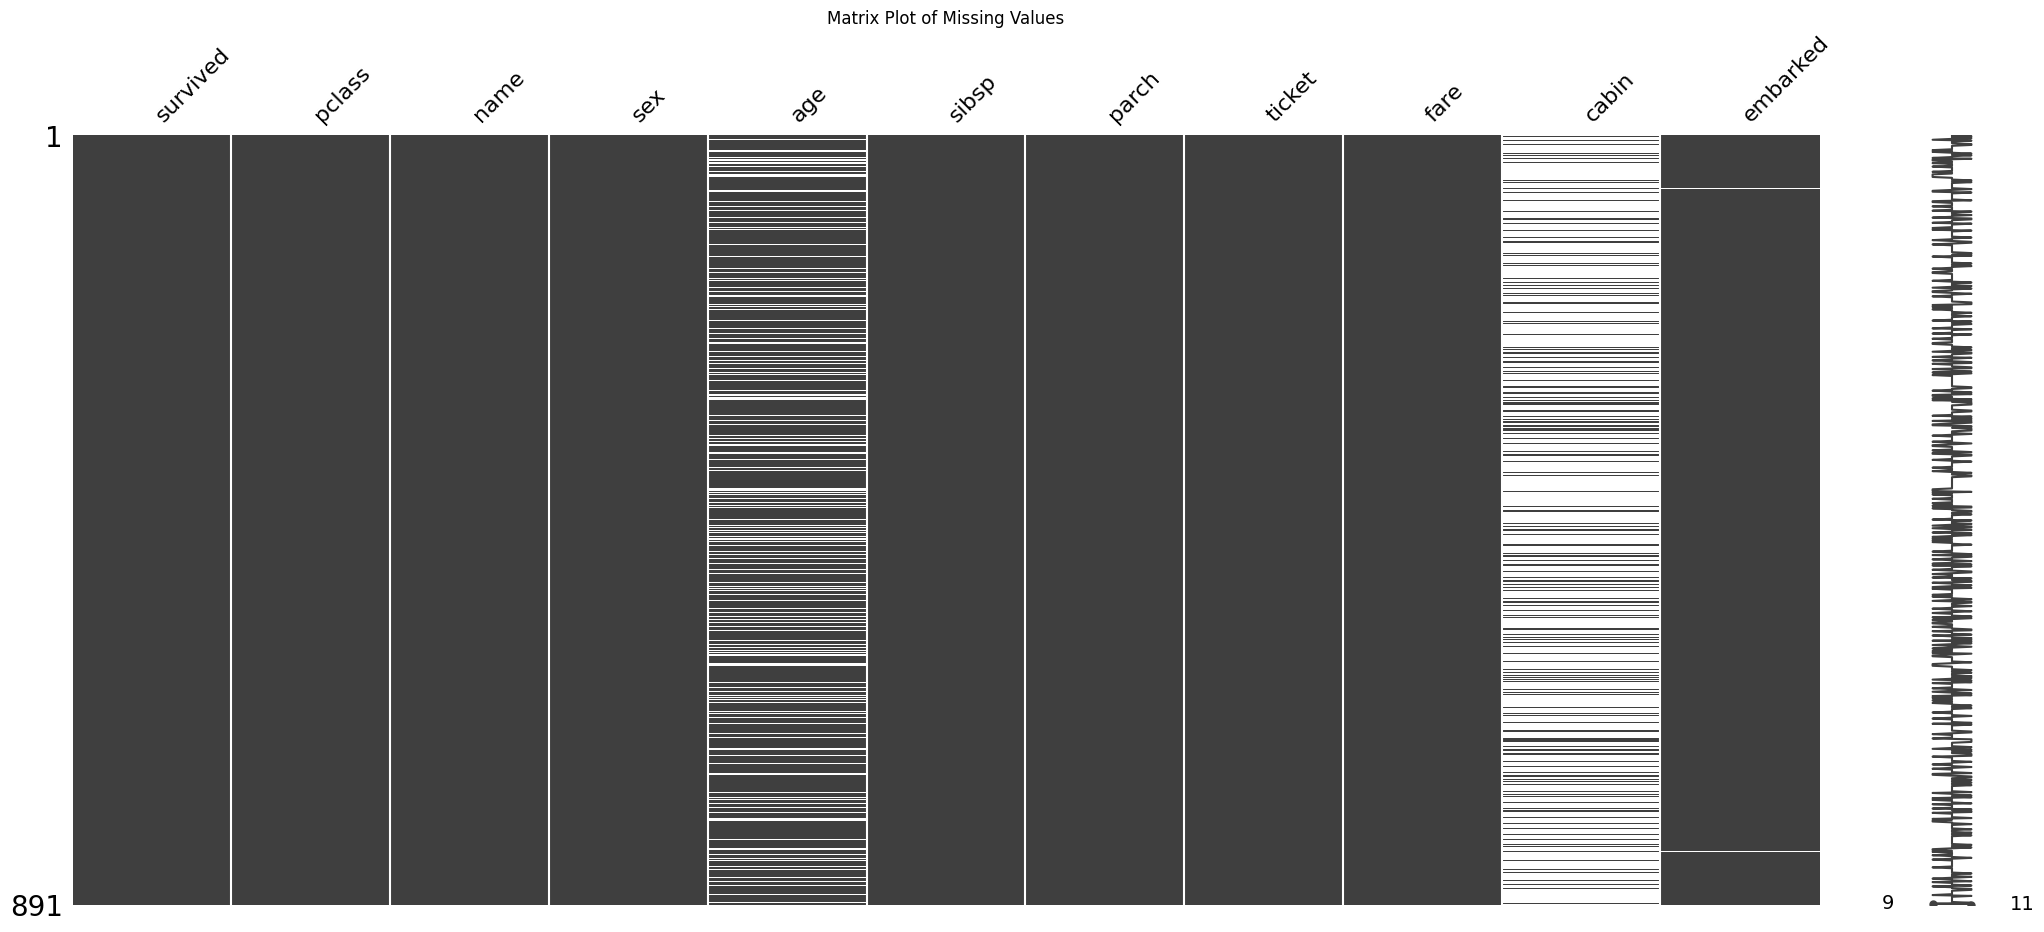

In [12]:

# Matrix plot
msno.matrix(titanic_data)
plt.title("Matrix Plot of Missing Values")

<Axes: >

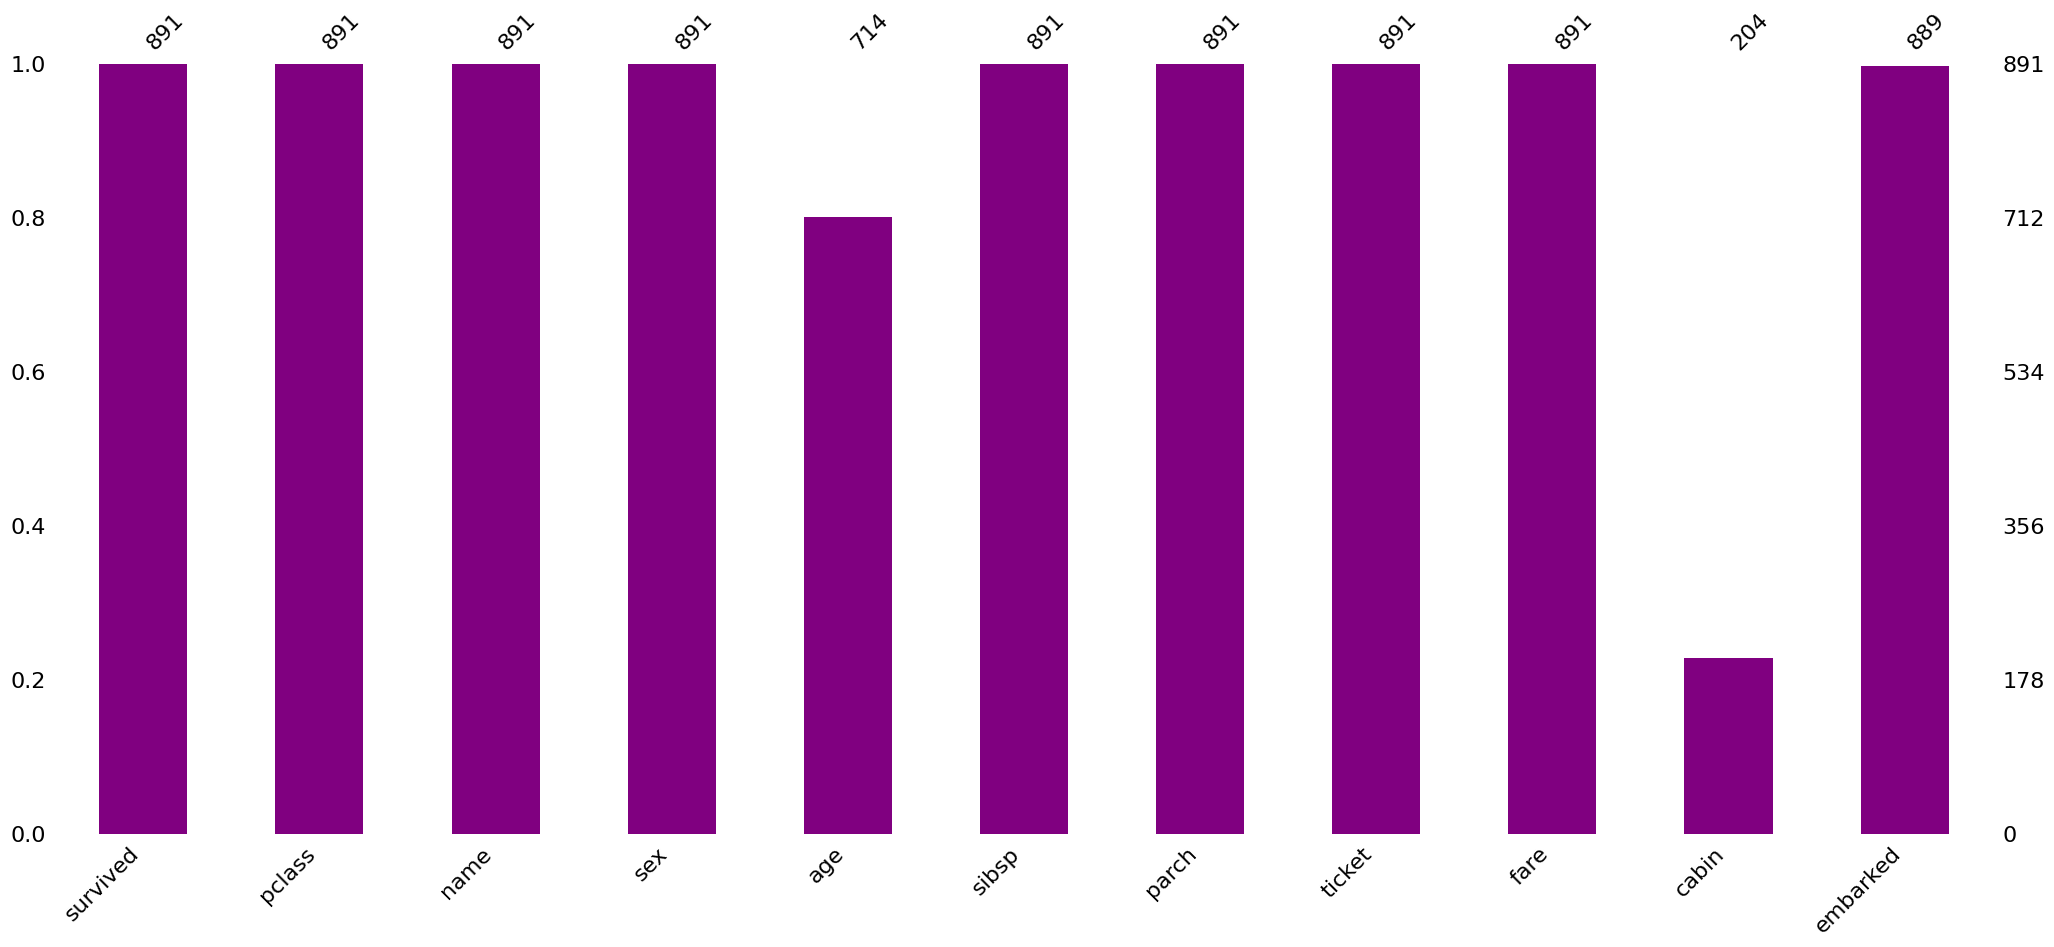

In [13]:
msno.bar(titanic_data, color='purple')

This code generates a matrix plot where each column represents a variable, and each row represents an observation. White spaces indicate missing values, allowing you to visualize patterns of missingness across your dataset.

In [14]:
# Check the number of missing values in each column
missing_count = titanic_data.isnull().sum()

# Calculate percentage of missing values
mising_percentages = 100 * titanic_data.isnull().sum() / len(titanic_data)

# Combine counts and percentages in a single dataframe
missing_table = pd.concat(
    [missing_count, mising_percentages],
    axis = 1,
    keys = ['Missing count', 'Mising percentages'],
)
missing_table

,Missing count,Mising percentages
survived,0,0.000000
pclass,0,0.000000
name,0,0.000000
sex,0,0.000000
age,177,19.865320
sibsp,0,0.000000
parch,0,0.000000
ticket,0,0.000000
fare,0,0.000000
cabin,687,77.104377


In [15]:
def categorize_missing(df, threshold = 5):
  mising_percentages = 100 * titanic_data.isnull().sum() / len(titanic_data)

  no_missing = mising_percentages[mising_percentages == 0].index.tolist()
  low_missing = mising_percentages[
      (mising_percentages > 0) & (mising_percentages <= threshold)
      ].index.tolist()

  high_missing = mising_percentages[mising_percentages > threshold].index.tolist()

  print(f'Variables with no missing data: {no_missing}')
  print(f'Variables with low missing data: ( <= {threshold}%) : {low_missing}')
  print(f'Variables with high missing data: ( > {threshold}%) : {high_missing}')

categorize_missing(titanic_data)

Variables with no missing data: ['survived', 'pclass', 'name', 'sex', 'sibsp', 'parch', 'ticket', 'fare']
Variables with low missing data: ( <= 5%) : ['embarked']
Variables with high missing data: ( > 5%) : ['age', 'cabin']


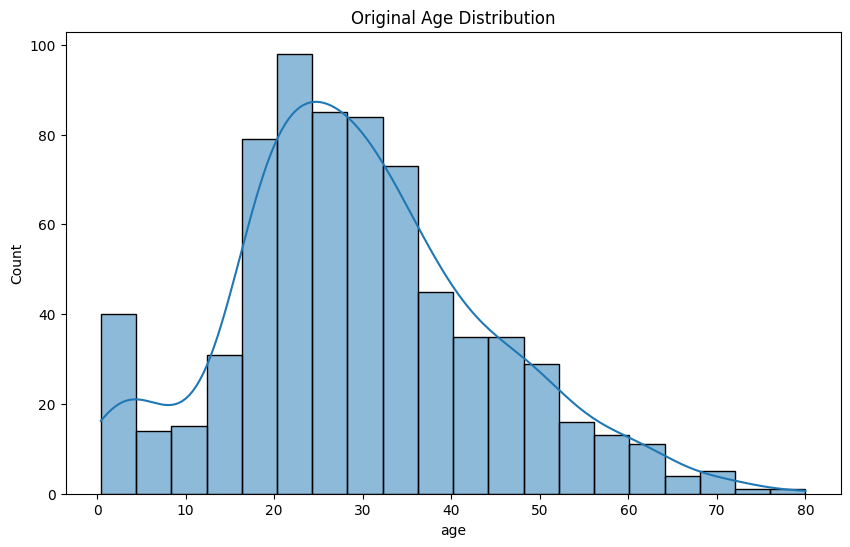

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(titanic_data['age'], kde=True)
plt.title('Original Age Distribution')
plt.show()


In [17]:
# # Replasing the missing values in "Age" column with mean value
titanic_data['age'].fillna(titanic_data['age'].mean(), inplace=True)

/tmp/ipython-input-2844534434.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['age'].fillna(titanic_data['age'].mean(), inplace=True)


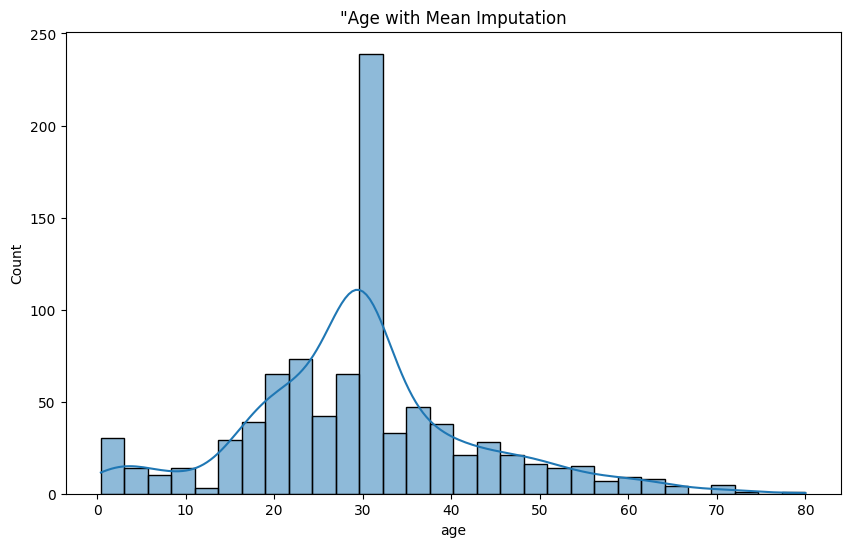

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(titanic_data['age'], kde=True)
plt.title('"Age with Mean Imputation')
plt.show()

In [19]:
# Finding the mode value of "Embarked" column
print(titanic_data['embarked'].mode())
print(titanic_data['embarked'].mode()[0])

0    S
Name: embarked, dtype: object
S


In [20]:
# Replacing the missing value in "Embarked" column with mode value
titanic_data['embarked'].fillna(titanic_data['embarked'].mode()[0], inplace=True)

/tmp/ipython-input-2271594206.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['embarked'].fillna(titanic_data['embarked'].mode()[0], inplace=True)


In [21]:
# Check the number of missing values in each column
titanic_data.isnull().sum()

,0
survived,0
pclass,0
name,0
sex,0
age,0
sibsp,0
parch,0
ticket,0
fare,0
cabin,687


## Data Analysis

In [22]:
# Getting some statistical measures about the data
titanic_data.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
# Finding the number of people survived and not survived
titanic_data['survived'].value_counts()

,count
survived,
0,549
1,342


## Data Visualization

In [ ]:
sns.set()

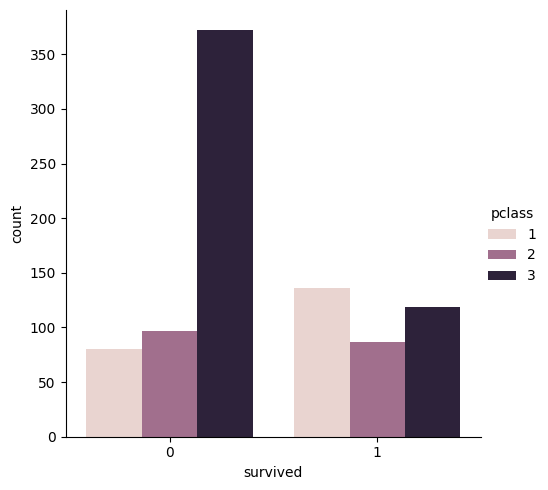

In [26]:
# Making a count plot for "Survived" column
sns.catplot(
    x='survived',
    data=titanic_data,
    hue= 'pclass',
    kind='count',
    )

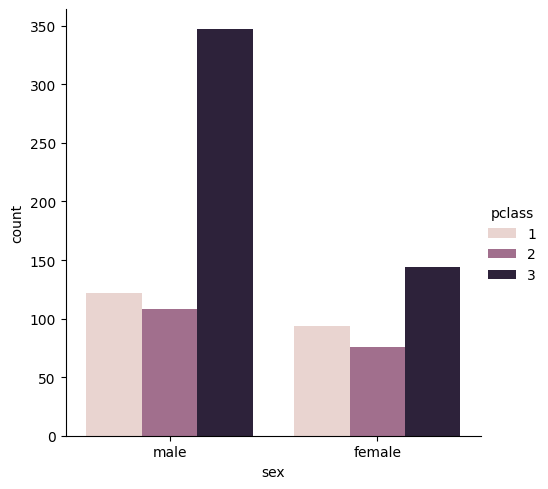

In [27]:
sns.catplot(
    x='sex',
    data=titanic_data,
    hue= 'pclass',
    kind='count',
    )

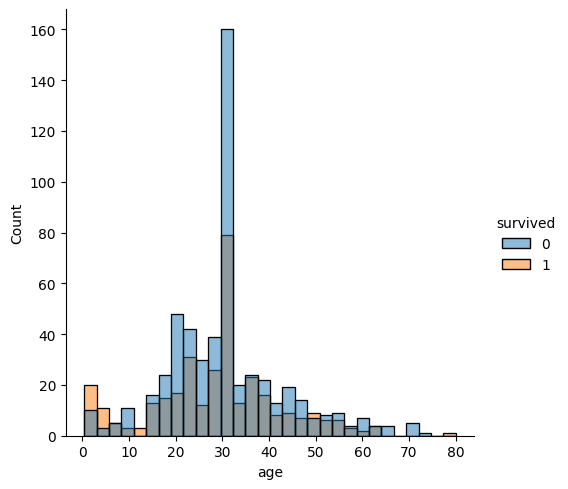

In [30]:
sns.displot(
    x='age',
    data=titanic_data,
    hue='survived',
    bins=30,
    )

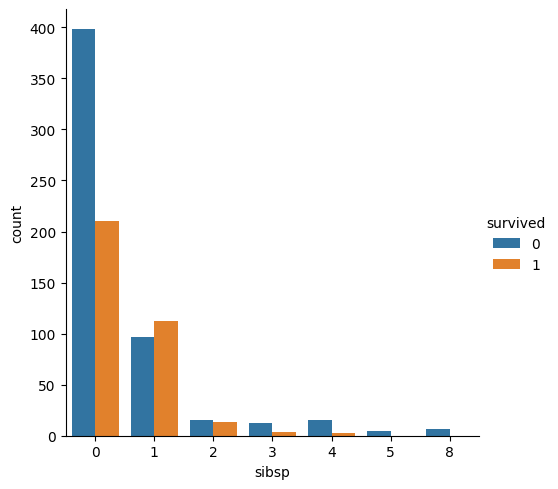

In [31]:
sns.catplot(
    data=titanic_data,
    x='sibsp',
    hue='survived',
    kind='count',
)

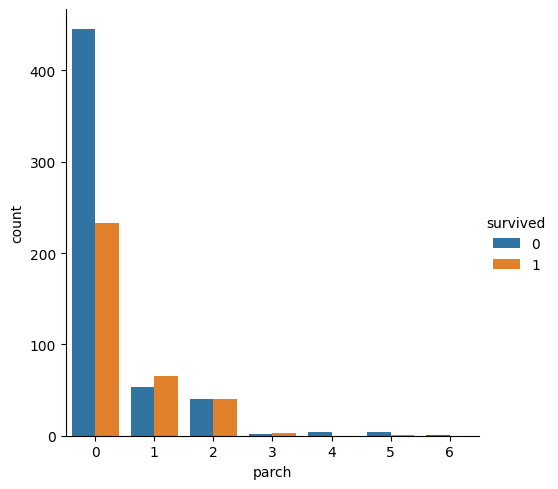

In [32]:
sns.catplot(
    data=titanic_data,
    x='parch',
    hue='survived',
    kind='count',
)

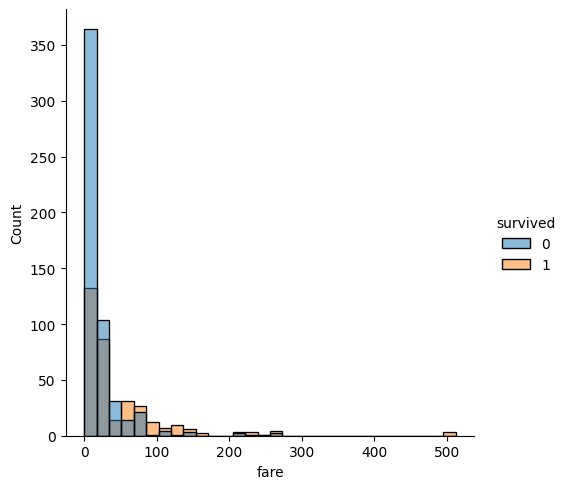

In [33]:
sns.displot(
    data=titanic_data,
    x='fare',
    hue='survived',
    bins=30,
)

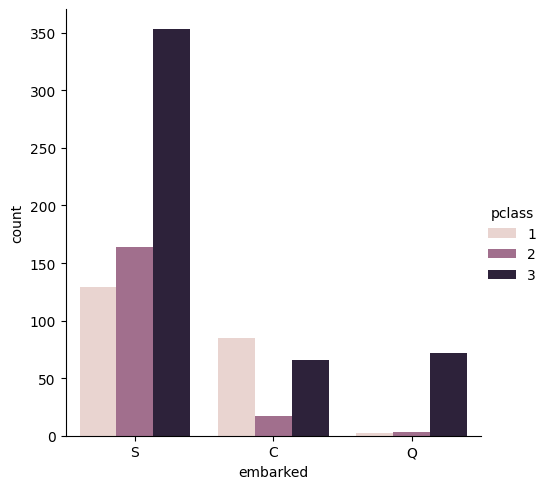

In [35]:
sns.catplot(
    data=titanic_data,
    x='embarked',
    hue='pclass',
    kind='count',
)

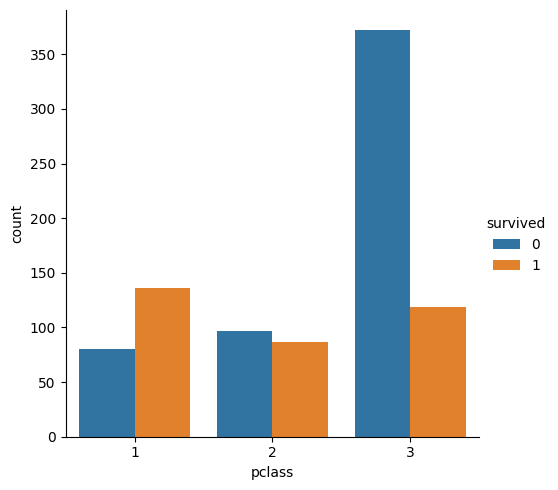

In [36]:
sns.catplot(
    data=titanic_data,
    x='pclass',
    hue='survived',
    kind='count',
)

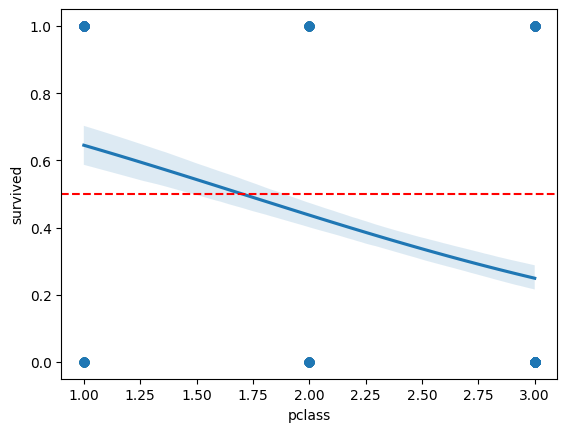

In [38]:
ax = sns.regplot(
    data=titanic_data,
    x='pclass',
    y='survived',
    logistic=True,
)
plt.axhline(0.5, color='red', linestyle='--')

In [ ]:
titanic_data['sex'].value_counts()

,count
sex,
male,577
female,314


<Axes: xlabel='sex', ylabel='count'>

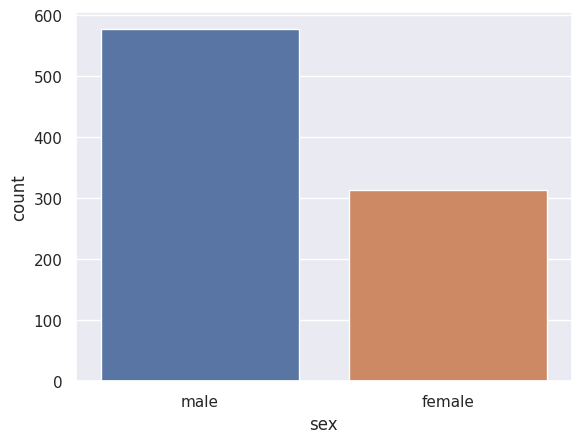

In [ ]:
sns.countplot(x= 'sex', data= titanic_data, hue='sex')

<Axes: >

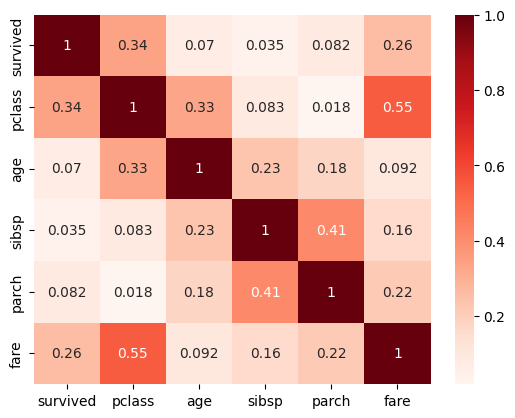

In [40]:
titanic_numerical= titanic_data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(
    abs(titanic_numerical.corr()),
    annot=True,
    cmap='Reds',
)

##  Feature Engineering

In [ ]:
# Create new feature: FamilySize
titanic_data['FamilySize'] = titanic_data['sibsp'] + titanic_data['parch']

# Create new feature: IsAlone
titanic_data['IsAlone'] = (titanic_data['FamilySize'] == 0).astype(int)



In [39]:
titanic_data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Encoding the Categorical Columns

In [ ]:
titanic_data['sex'].value_counts()

,count
sex,
male,577
female,314


In [ ]:
titanic_data['embarked'].value_counts()

,count
embarked,
S,646
C,168
Q,77


In [ ]:
# Converting categorical columns
titanic_data.replace({
    'sex':{'male':0,
            'female':1},
    'embarked':{
        'S':0,
        'C':1,
        'Q':2
    }
}, inplace=True)

/tmp/ipython-input-29-1266477844.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titanic_data.replace({


In [ ]:
titanic_data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,FamilySize,IsAlone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1


## Separating Features & Targets

In [ ]:
X= titanic_data.drop(columns=['name','cabin', 'ticket','survived'], axis=1)
Y = titanic_data['survived']

In [ ]:
print(X)

     pclass  sex        age  sibsp  parch     fare  embarked  FamilySize  \
0         3    0  22.000000      1      0   7.2500         0           1   
1         1    1  38.000000      1      0  71.2833         1           1   
2         3    1  26.000000      0      0   7.9250         0           0   
3         1    1  35.000000      1      0  53.1000         0           1   
4         3    0  35.000000      0      0   8.0500         0           0   
..      ...  ...        ...    ...    ...      ...       ...         ...   
886       2    0  27.000000      0      0  13.0000         0           0   
887       1    1  19.000000      0      0  30.0000         0           0   
888       3    1  29.699118      1      2  23.4500         0           3   
889       1    0  26.000000      0      0  30.0000         1           0   
890       3    0  32.000000      0      0   7.7500         2           0   

     IsAlone  
0          0  
1          0  
2          1  
3          0  
4          1

In [ ]:
print(Y)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64


## Splitting the data into Traning data & Test data

80% of the data is used for training and 20% for testing to ensure generalization.

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [ ]:
print(X.shape, x_train.shape, x_test.shape)

(891, 9) (712, 9) (179, 9)


## Model Training

### Logistic Regression

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

We use Logistic Regression model for binary classification.




In [ ]:
logistic_model = LogisticRegression(max_iter=1000)

In [ ]:
# Training the Logestic Regression model with training data
logistic_model.fit(x_train_scaled, y_train)

## Model Evaluation

### Accuracy Score

In [ ]:
# Accuracy on traning data
y_train_pred_logistic = logistic_model.predict(x_train_scaled)

In [ ]:
print(y_train_pred_logistic)

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1
 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1
 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 

In [ ]:
training_data_acc_logistic = accuracy_score(y_train, y_train_pred_logistic)
print(f"Accuracy on training data: {training_data_acc_logistic}")

Accuracy on training data: 0.8174157303370787


In [ ]:
# Accuracy on test data
y_test_pred_logistic = logistic_model.predict(x_test_scaled)

In [ ]:
print(y_test_pred_logistic)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1]


In [ ]:
test_data_acc_logistic = accuracy_score(y_test, y_test_pred_logistic)
print(f"Accuracy on test data: {test_data_acc_logistic}")

Accuracy on test data: 0.770949720670391


## Model Training


## XGBoost

In [ ]:
XGBoost_model = XGBClassifier()

In [ ]:
XGBoost_model.fit(x_train, y_train)

## Model Evaluation

### Accuracy Score

In [ ]:
# Accuracy on traning data
y_train_pred_xgboost = XGBoost_model.predict(x_train)

In [ ]:
print(y_train_pred_xgboost)

[0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 

In [ ]:
training_data_acc_xgboost = accuracy_score(y_train, y_train_pred_xgboost)
print(f"Accuracy on training data: {training_data_acc_xgboost}")

Accuracy on training data: 0.9719101123595506


In [ ]:
# Accuracy on test data
y_test_pred_xgboost =XGBoost_model.predict(x_test)

In [ ]:
print(y_test_pred_xgboost)

[1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0
 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1]


In [ ]:
test_data_acc_xgboost = accuracy_score(y_test, y_test_pred_xgboost)
print(f"Accuracy on test data: {test_data_acc_xgboost}")

Accuracy on test data: 0.7821229050279329


## Model Training

## Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier()

In [ ]:
tree_model.fit(x_train, y_train)

## Model Evaluation

### Accuracy Score

In [ ]:
# Accuracy on traning data
y_train_pred_tree = tree_model.predict(x_train)

In [ ]:
print(y_train_pred_tree)

[0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 

In [ ]:
training_data_acc_tree = accuracy_score(y_train, y_train_pred_tree)
print(f"Accuracy on training data: {training_data_acc_tree}")

Accuracy on training data: 0.9859550561797753


In [ ]:
# Accuracy on test data
y_test_pred_tree = tree_model.predict(x_test)

In [ ]:
print(y_test_pred_tree)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0
 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1
 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0
 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1]


In [ ]:
test_data_acc_tree = accuracy_score(y_test, y_test_pred_tree)
print(f"Accuracy on test data: {test_data_acc_tree}")

Accuracy on test data: 0.7486033519553073


## Model Training

## Random Forest

In [ ]:
model_forest= RandomForestClassifier()

In [ ]:
model_forest.fit(x_train, y_train.squeeze())

## Model Evaluation

### Accuracy Score

In [ ]:
# Accuracy on traning data
y_train_pred_forest = model_forest.predict(x_train)

In [ ]:
print(y_train_pred_forest)

[0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 

In [ ]:
training_data_acc_forest = accuracy_score(y_train, y_train_pred_forest)
print(f"Accuracy on training data: {training_data_acc_forest}")

Accuracy on training data: 0.9859550561797753


In [ ]:
# Accuracy on test data
y_test_pred_forest = model_forest.predict(x_test)

In [ ]:
print(y_test_pred_forest)

[1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1
 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0]


In [ ]:
test_data_acc_forest = accuracy_score(y_test, y_test_pred_forest)
print(f"Accuracy on test data: {test_data_acc_forest}")

Accuracy on test data: 0.8100558659217877


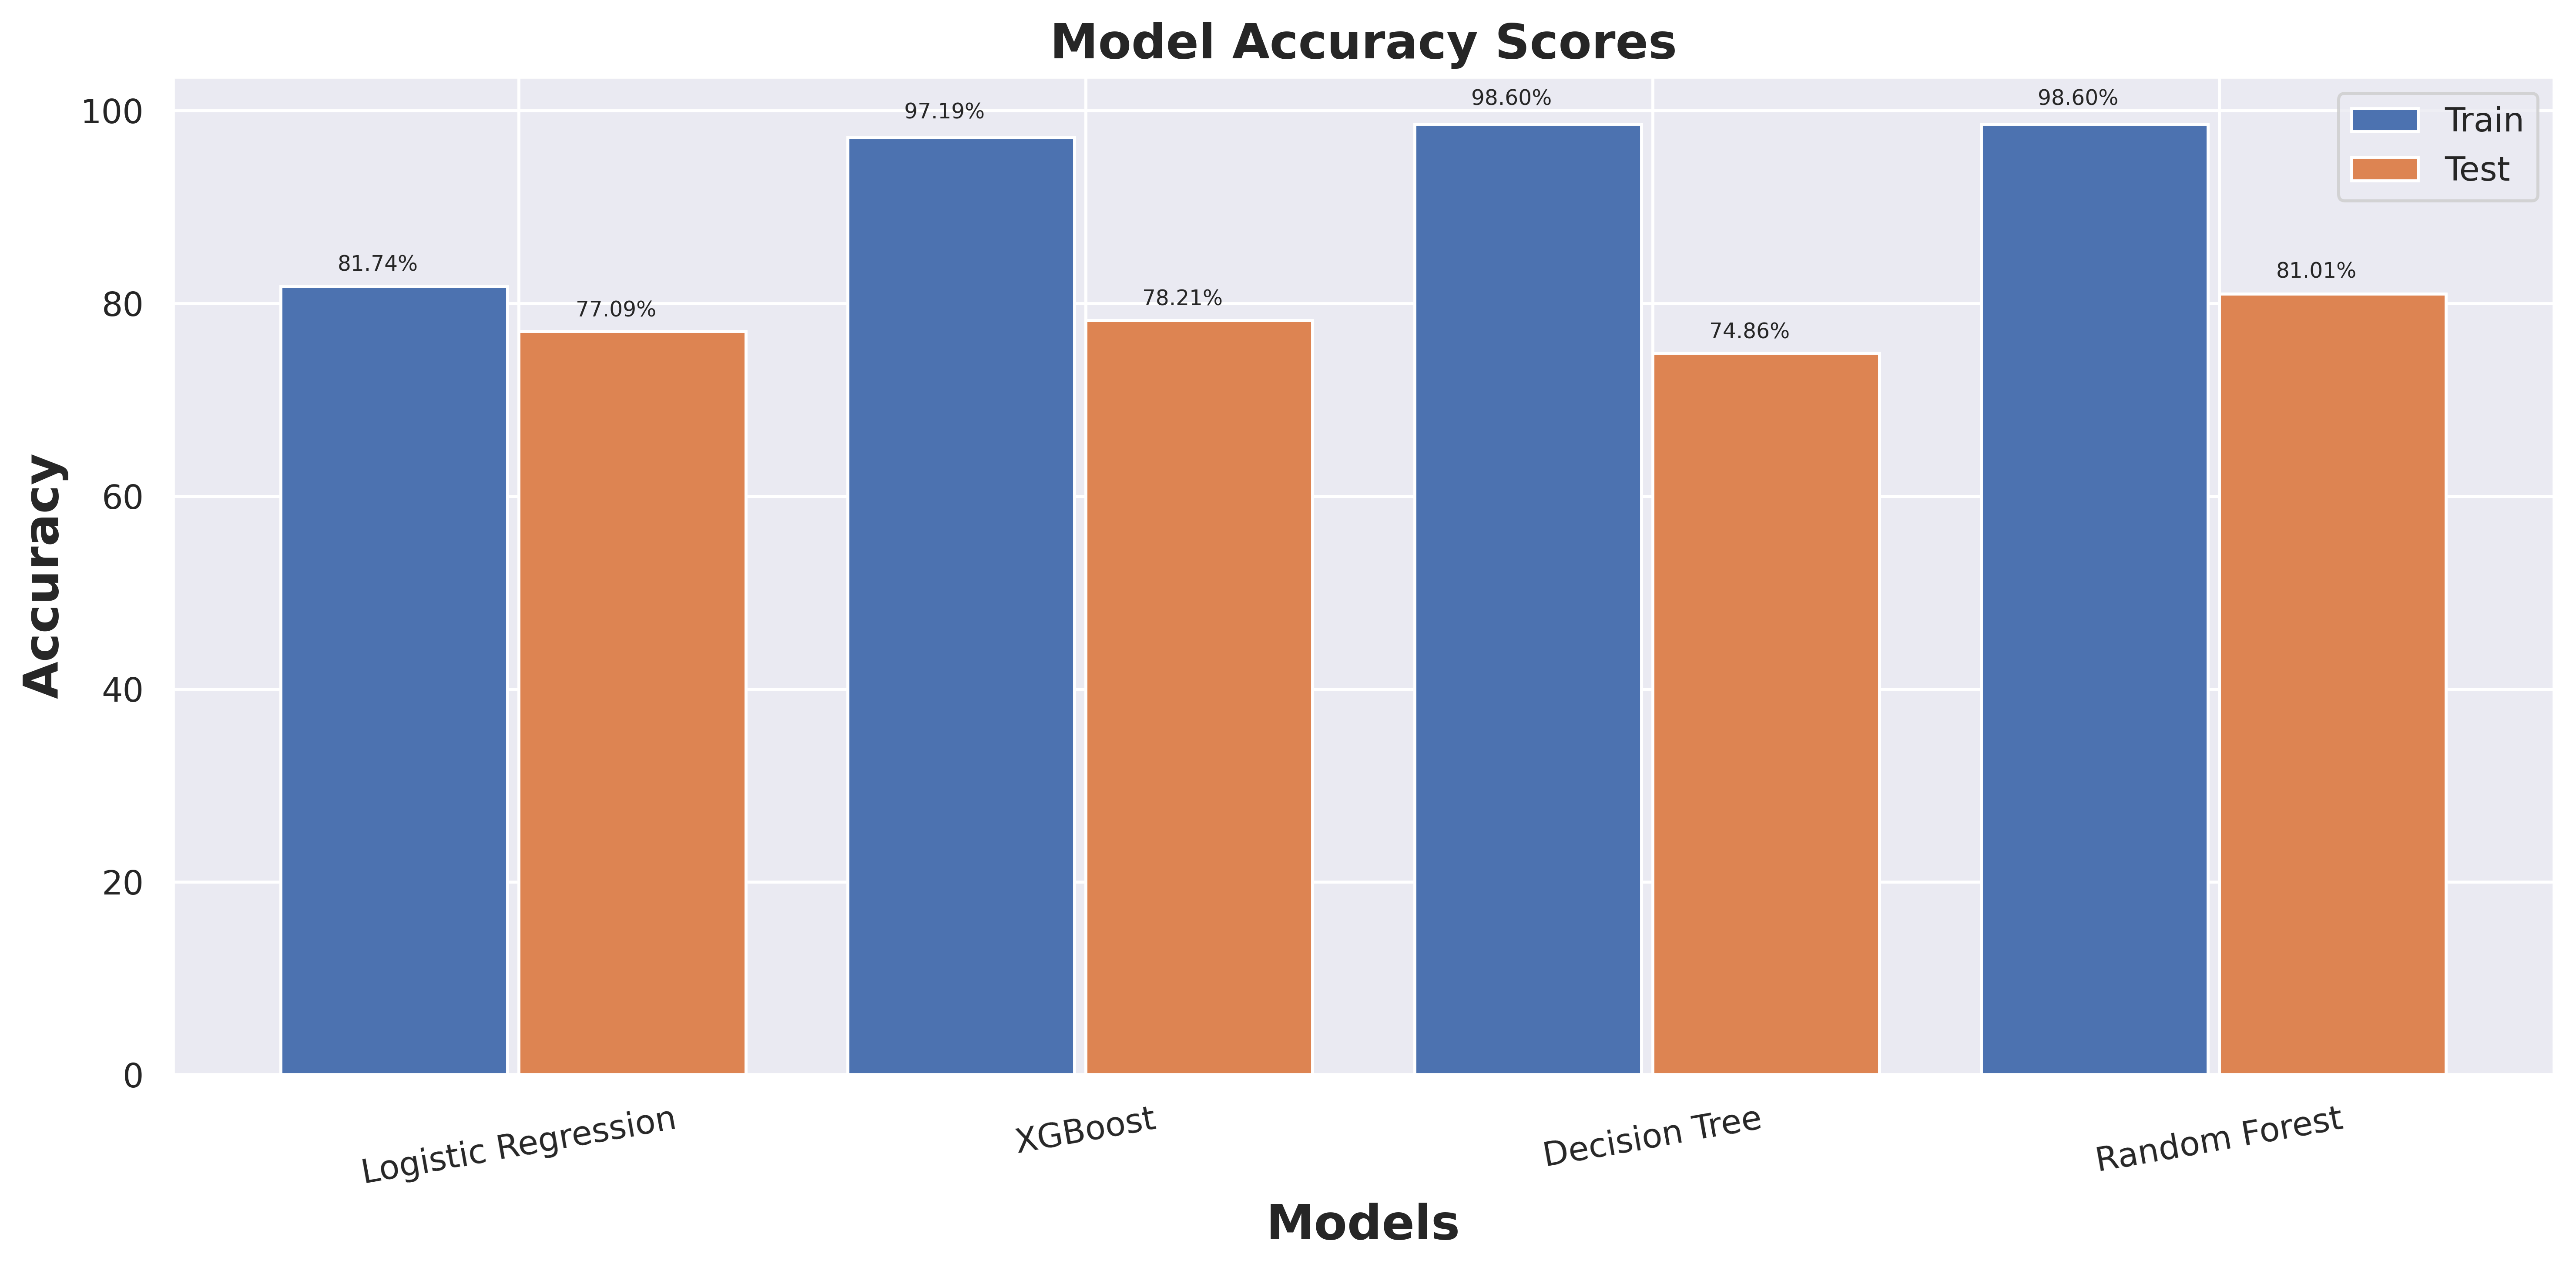

In [ ]:
models_train_acc = [training_data_acc_logistic  * 100, training_data_acc_xgboost  * 100, training_data_acc_tree  * 100, training_data_acc_forest  * 100]
models_test_acc = [test_data_acc_logistic  * 100, test_data_acc_xgboost  * 100, test_data_acc_tree  * 100, test_data_acc_forest  * 100]
models_names = ['Logistic Regression', 'XGBoost', 'Decision Tree', 'Random Forest']

fig, axs = plt.subplots(1, 1, figsize=(12, 6), dpi=500)
x_pos = np.arange(4)


bar1 = plt.bar(x_pos - 0.22, models_train_acc, width = 0.4, label='Train')
bar2 = plt.bar(x_pos + 0.2, models_test_acc, width = 0.4, label = 'Test')
plt.xticks(x_pos, models_names)

plt.xlabel('Models', fontsize = 16, fontweight = 'bold')
plt.ylabel('Accuracy', fontsize = 16, fontweight = 'bold')
plt.title('Model Accuracy Scores', fontsize = 16, fontweight = 'bold')
plt.xticks(rotation = 10)
plt.legend()

for i,bar in enumerate(bar1):
  plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() * 1.02,
           s = '{:.2f}%'.format(models_train_acc[i]), fontsize = 7)

for i,bar in enumerate(bar2):
  plt.text(bar.get_x() + bar.get_width()/2 - 0.1, bar.get_height() * 1.02,
           s = '{:.2f}%'.format(models_test_acc[i]), fontsize = 7)

plt.tight_layout()
plt.show()

# Hypothesis Testing on Model Performance

## Objective
Compare the accuracy of Logistic Regression and Random Forest to determine if Random Forest performs significantly better in predicting Titanic passenger survival.

## Hypothesis
- **Null Hypothesis (H0)**: No significant difference in accuracy between Random Forest and Logistic Regression.
- **Alternative Hypothesis (H1)**: Random Forest has higher accuracy.

## Methodology
1. Use 5-fold cross-validation to compute accuracy scores.
2. Perform a paired t-test (α=0.05) to compare model accuracies.
3. Visualize results with a bar chart showing mean accuracies and standard deviations.

## Expected Outcome
- If p < 0.05, Random Forest significantly outperforms Logistic Regression.
- If p ≥ 0.05, no significant difference in accuracy.

The following code implements this analysis.

Logistic Regression CV Scores: [0.83916084 0.81818182 0.81690141 0.78873239 0.79577465]
Mean CV Accuracy (Logistic Regression): 0.8117502216093765
Random Forest CV Scores: [0.83916084 0.81818182 0.84507042 0.74647887 0.77464789]
Mean CV Accuracy (Random Forest): 0.8047079680882497

Paired t-test between Logistic Regression and Random Forest:
t-statistic: 0.5976
p-value: 0.5823
Fail to reject the null hypothesis: No significant difference in accuracy.


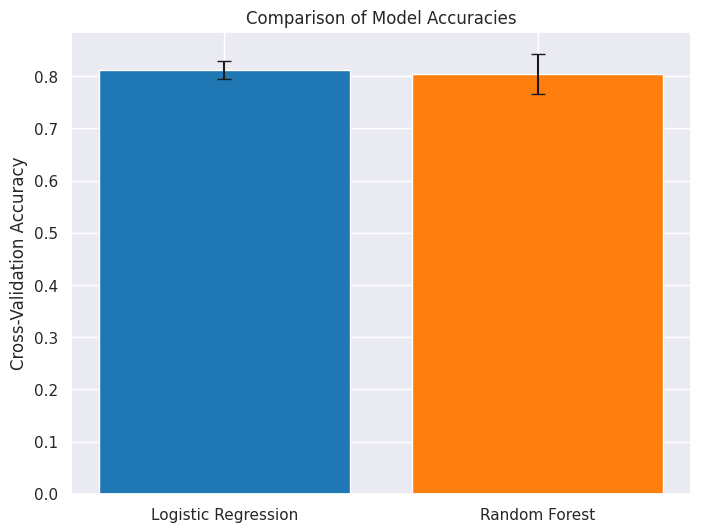

In [ ]:

# Perform 5-fold cross-validation with scaled data
logistic_scores = cross_val_score(logistic_model, x_train_scaled, y_train, cv=5, scoring='accuracy')
random_forest_scores = cross_val_score(model_forest, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Logistic Regression CV Scores:", logistic_scores)
print("Mean CV Accuracy (Logistic Regression):", np.mean(logistic_scores))
print("Random Forest CV Scores:", random_forest_scores)
print("Mean CV Accuracy (Random Forest):", np.mean(random_forest_scores))

# Perform paired t-test
t_stat, p_val = ttest_rel(logistic_scores, random_forest_scores)
print(f"\nPaired t-test between Logistic Regression and Random Forest:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# Interpret the results
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Random Forest significantly outperforms Logistic Regression.")
else:
    print("Fail to reject the null hypothesis: No significant difference in accuracy.")

# Visualize cross-validation accuracies
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'],
        [np.mean(logistic_scores), np.mean(random_forest_scores)],
        yerr=[np.std(logistic_scores), np.std(random_forest_scores)],
        capsize=5, color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Cross-Validation Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

## Significance and Challenges
The prediction of survival in the Titanic dataset is significant because it provides insights into historical survival patterns, which can inform modern safety protocols in transportation and emergency response systems. Understanding key predictors such as gender and passenger class can help prioritize resources in crisis situations, potentially saving lives in similar scenarios. This analysis also serves as a benchmark for binary classification problems in data science, with applications in risk assessment and predictive analytics.

However, several challenges were encountered during the analysis:
- **Missing Data**: The dataset contains missing values, particularly in the `Age` (approximately 20% missing) and `Cabin` (over 70% missing) columns, which required imputation techniques such as mean or median imputation for `Age` and exclusion or categorical encoding for `Cabin`.
- **Class Imbalance**: The dataset is imbalanced, with approximately 62% non-survivors (Survived=0) and 38% survivors (Survived=1), which can bias model predictions toward the majority class.
- **Feature Selection**: Selecting relevant features (e.g., excluding `Name` or `Ticket`) and engineering new ones (e.g., family size from `SibSp` and `Parch`) were critical to improving model performance.
- **Model Complexity**: Balancing model complexity to avoid overfitting, especially with tree-based models like Decision Tree and Random Forest, required careful consideration of hyperparameters.

Addressing these challenges involved preprocessing techniques, feature engineering, and evaluating multiple models to ensure robust predictions.

##  Conclusion
- Gender and passenger class are significant predictors of survival.
- All algorithm perform reasonably well.
- Future work can explore ensemble models with hyperparameter tuning and cross-validation.

##  References and Citations
- Dataset: https://www.kaggle.com/c/titanic
- Python Libraries: pandas, numpy, seaborn, matplotlib, scikit-learn, scipy, xgboost
- Scikit-learn documentation: https://scikit-learn.org/
- XGBoost documentation: https://xgboost.readthedocs.io/
